In [1]:
from Assemblies.game import GameField
import numpy as np
from numpy import random
import time
import scipy.stats as ss

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
eps=0.01
bs=9/5+eps
L=100
cp=50

offp=np.linspace(80,0,num=20,dtype=int)

#в статье написано "100 samples", но пусть пока будет 10
seeds=np.zeros(10,dtype=int)
for i in range(10):
    seeds[i]=i+1

    
#информации по шагам отжига и эволюции я в статье не нашёл, поэтому пусть будет 3000 и 500 соответственно
burnin1=3000
evol1=500

In [4]:
#плотность для конкретного b
def c_density(size, coop_percentage, off_percentage, seed, burnin, evol, b): 
    random.seed(seed)
    instance = np.array(np.random.rand(size, size) <= 0.01 * off_percentage, dtype=int) * (-1)
    #здесь active означает места, занятые кооператорами или дефекторами
    active_indexes=(-1-instance).nonzero()
    active_size=active_indexes[0].size
    active = np.array(np.random.rand(active_size) > 0.01 * coop_percentage, dtype=int)
    instance[active_indexes]=np.copy(active)

    density = np.zeros(evol)
    
    game = GameField(size, b)
    game.field = np.copy(instance)
    game.evolveQ(burnin)
    for step in range(evol):
        game.evolveQ(1)
        density[step] = np.count_nonzero(np.equal(game.field,0)) / size**2
    return density

In [5]:
#измеряем плотность для одной реализации на протяжении evol1 шагов. 
#усредняем по шагам.

#функция возвращает массив плотности по значениям off_percentage для определённого процента кооператоров и определённого b
def total_density(size, coop_percentage, off_percentage, seed, burnin, evol, b):
    
    aver_all=np.zeros(len(off_percentage))
    for i in range(len(off_percentage)):
        den=np.zeros(evol)
        den=c_density(size, coop_percentage, off_percentage[i], seed, burnin, evol, b)
        aver_all[i]=np.mean(den)

    return aver_all 

In [6]:
den1 = total_density(size=L, coop_percentage=cp, off_percentage=offp, seed=seeds[0], burnin=burnin1, evol=evol1, b=bs)
for i in range(1, len(seeds)):
    den2 = total_density(size=L, coop_percentage=cp, off_percentage=offp, seed=seeds[i], burnin=burnin1, evol=evol1, b=bs)
    if ss.ttest_ind(den1, den2)[1] <= 0.1:
        print('Warning')
        break
    den1 = den2

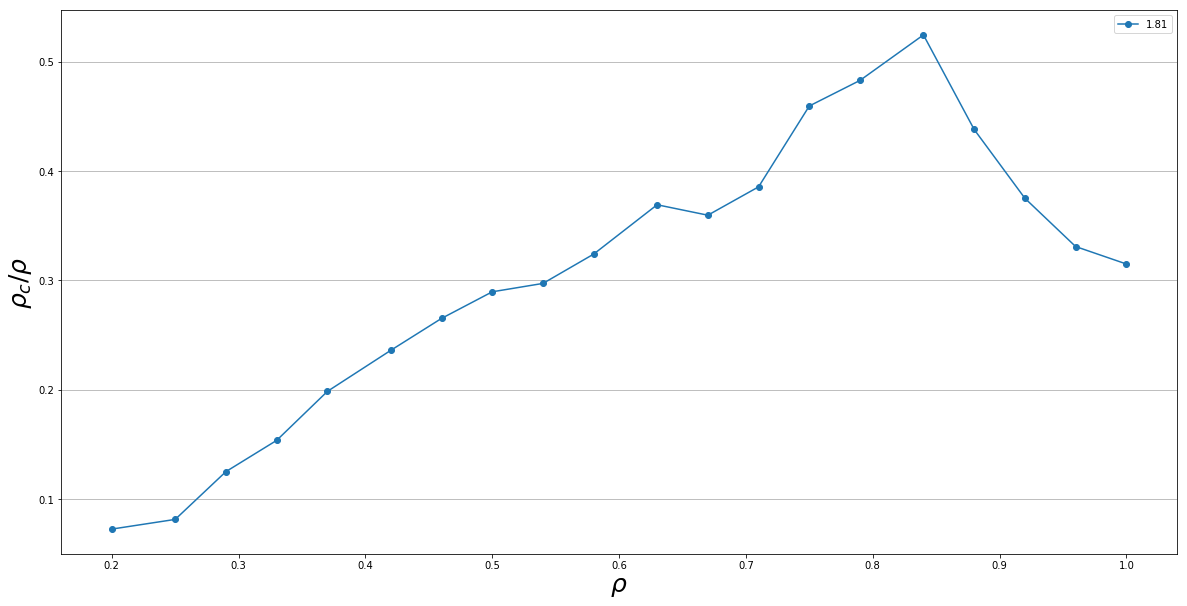

In [11]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
ax.grid(b=True,axis='y')
ax.plot(1-offp*0.01, den1,'o-',label=bs)

ax.set_xlabel('$%s$'%'\\rho',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c/\\rho',fontsize=25)
ax.legend()    

In [12]:
maxind=np.argmax(den1)
p_star=(100-offp)[maxind]
print('критический процент заполненности решётки p* = ', p_star)

критический процент заполненности решётки p* =  84


## Persistence

In [6]:
#массив значений persistence на протяжении t-tw шагов для определённой реализации игры
def persistence(size, coop_percentage, off_percentage, seed, b, t, tw):
    random.seed(seed)
    instance = np.array(np.random.rand(size, size) <= 0.01 * off_percentage, dtype=int) * (-1)
    active_indexes=(-1-instance).nonzero()
    active_size=active_indexes[0].size
    active = np.array(np.random.rand(active_size) > 0.01 * coop_percentage, dtype=int)
    instance[active_indexes]=np.copy(active)
    
    c=active_size
    persistence=np.zeros(t-tw)
    
    #флаги индексы элементов
    #0 - прошёл проверку на неизменность стратегий, 1 - не прошёл
    dropout_flags=np.zeros(active_size, dtype=int) 
    
    game = GameField(size, b)
    game.field = np.copy(instance)
    game.evolveQ(tw)
    for step in range(t-tw):
        game.evolveQ(1)
        
        evolution=np.copy(game.field[active_indexes])
        
        for i in range(len(evolution)):
            if (dropout_flags[i]!=1) and (evolution[i]!=active[i]):
                c-=1
                dropout_flags[i]=1
        
        persistence[step]=c/active_size
    return persistence

In [14]:
points31=np.linspace(90,0,num=50,dtype=int)
t1=1000
tw1=0

In [18]:
pers31=np.zeros(len(points31))
for i in range(len(points31)):
    pers31[i]=persistence(size=100,coop_percentage=50,off_percentage=points31[i],seed=seeds[0],b=bs,t=t1,tw=tw1)[-1]
    
for j in range(1, len(seeds)):
    pers32=np.zeros(len(points31))
    for i in range(len(points31)):
        pers32[i] = persistence(size=100,coop_percentage=50,off_percentage=points31[i],seed=seeds[j],b=bs,t=t1,tw=tw1)[-1]
    if ss.ttest_ind(pers31, pers32)[1] <= 0.1:
        print('Warning, seed:', seeds[j])
        break
    pers31 = pers32

In [30]:
pers=np.zeros((len(seeds), len(points31)))
for j in range(len(seeds)):
    for i in range(len(points31)):
        pers[0][i]=persistence(size=100,coop_percentage=50,off_percentage=points31[i],seed=seeds[0],b=bs,t=t1,tw=tw1)[-1]

In [35]:
all_pers = np.mean(pers, axis=0)

In [36]:
all_pers.shape

(50,)

(0, 0.01)

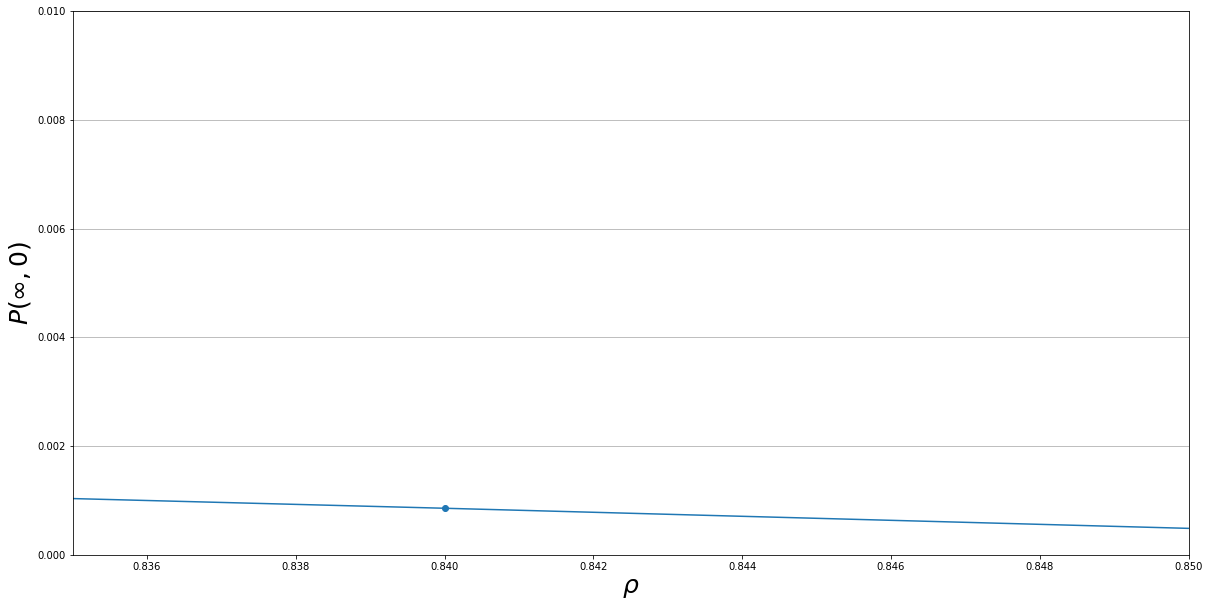

In [40]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
ax.grid(b=True,axis='y')

ax.plot(1-0.01*points31, all_pers,'o-')
    
ax.set_xlabel('$%s$'%'\\rho',fontsize=25)
ax.set_ylabel('$%s$'%'P(\\infty,0)',fontsize=25)
ax.set_xlim(.835, .85)
ax.set_ylim(0, 0.01)

In [50]:
points_close=np.linspace(75,95,num=20,dtype=int)
t1=1000
tw1=0

pers_close=np.zeros((len(seeds), len(points_close)))
for j in range(len(seeds)):
    for i in range(len(points_close)):
        pers_close[0][i]=persistence(size=100,coop_percentage=50,off_percentage=100 - points_close[i],seed=seeds[0],b=bs,t=t1,tw=tw1)[-1]
        
all_pers_close = np.mean(pers_close, axis=0)

(0.79, 0.84)

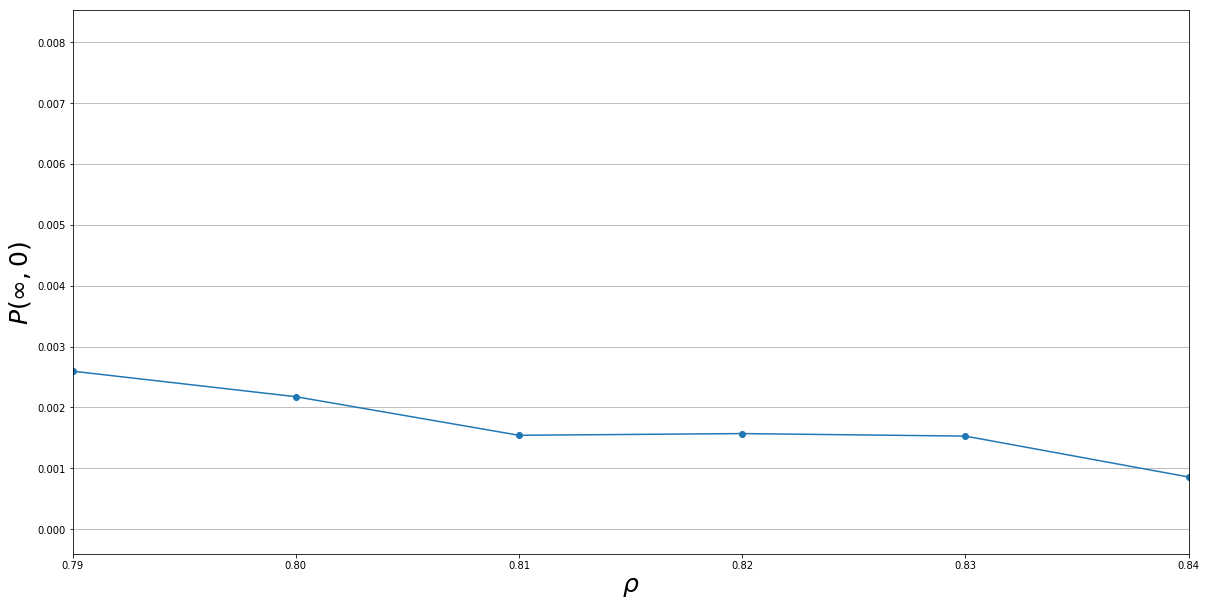

In [72]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
ax.grid(b=True,axis='y')

ax.plot(0.01*points_close, all_pers_close,'o-')
    
ax.set_xlabel('$%s$'%'\\rho',fontsize=25)
ax.set_ylabel('$%s$'%'P(\\infty,0)',fontsize=25)
ax.set_xlim(.79, .01 * p_star)
#ax.set_ylim(0, 0.01)

(0, 0.001)

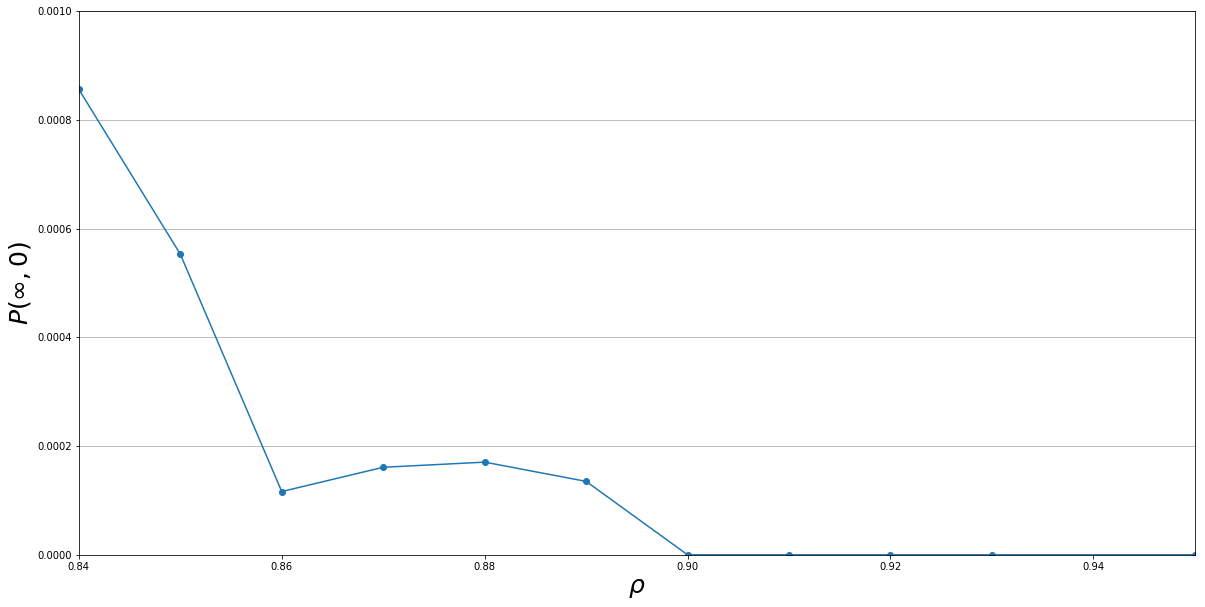

In [65]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
ax.grid(b=True,axis='y')

ax.plot(0.01*points_close, all_pers_close,'o-')
    
ax.set_xlabel('$%s$'%'\\rho',fontsize=25)
ax.set_ylabel('$%s$'%'P(\\infty,0)',fontsize=25)
ax.set_xlim(.01 * p_star, .95)
ax.set_ylim(0, 0.001)